[View in Colaboratory](https://colab.research.google.com/github/bz10bis/colaboratorySave/blob/master/AutoEncoder.ipynb)

# Variables

In [0]:
#@title Remplir toutes les valeurs { form-width: "600px" }
encoding_dim = 16 #@param {type:"slider", min:0, max:784, step:1}
input_dim = 784 #@param {type:"integer"}
model_optimizer = "adam" #@param ["adam", "sgd", "adadelta"]
encoded_activation = "relu" #@param ["relu", "sigmoid", "tanh"]
decoded_activation = "sigmoid" #@param ["sigmoid", "relu", "tanh"]
nbr_epochs = 100 #@param {type:"integer"}
loss_function = "binary_crossentropy" #@param ["binary_crossentropy", "mse"]
batchsize = 256


In [0]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import Callback, EarlyStopping
from IPython.display import clear_output

import matplotlib.pyplot as plt
import time

# Models

## Callbacks

In [0]:
class PlotModelLosses(Callback):
  def on_train_begin(self, logs={}):
    self.i = 0
    self.x = []
    self.losses = []
    self.val_losses = []
    self.fig = plt.figure()
    self.logs = []
    
  def on_epoch_end(self, epoch, logs={}):
    self.logs.append(logs)
    self.x.append(self.i)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))
    self.i += 1
    clear_output(wait=True)
    plt.plot(self.x, self.losses, label="loss")
    plt.plot(self.x, self.val_losses, label="val_loss")
    plt.legend()
    plt.title("Epochs: {}   Val_loss: {}".format(self.x[-1], round(self.losses[-1], 4)))
    plt.show();
        
pltL = PlotModelLosses()

early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0,
                           patience=3,
                           verbose=0,
                           mode='auto')

## Autoencoder Model

In [144]:
input_img = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation=encoded_activation)(input_img)
decoded = Dense(input_dim, activation=decoded_activation)(encoded)
autoencoder = Model(input_img, decoded)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 64)                50240     
_________________________________________________________________
dense_24 (Dense)             (None, 784)               50960     
Total params: 101,200
Trainable params: 101,200
Non-trainable params: 0
_________________________________________________________________


## Encoder model

In [0]:
encoder = Model(input_img, encoded)

## Decoder Model

In [0]:
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

# Training

In [0]:
autoencoder.compile(optimizer=model_optimizer, loss=loss_function)

## Data prep

In [0]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

In [149]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


## Fitting

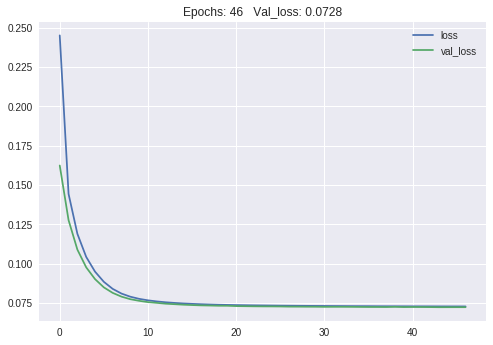

Time: 85.32 s


In [150]:
start_time = time.time()
autoencoder.fit(x_train, x_train,
                epochs=nbr_epochs,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test),
                verbose=0,
                callbacks=[pltL,early_stop])
elapse_time = time.time() - start_time
print("Time: {} s".format(round(time.time() - start_time, 2)))

In [0]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

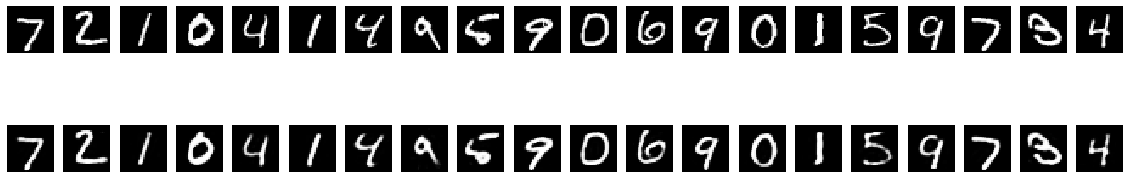

In [152]:
import matplotlib.pyplot as plt

n = 20  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [153]:
print(encoded_imgs.shape)

(10000, 64)
